In [1]:
import janus
import os
import timeit
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks,argrelmin
import imp
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

imp.reload(janus)

<module 'janus' from '/Users/zack/Documents/oscillators/snakingoscillators/janus.py'>

### A limit-cycle chimera state

runtime: 32.706777


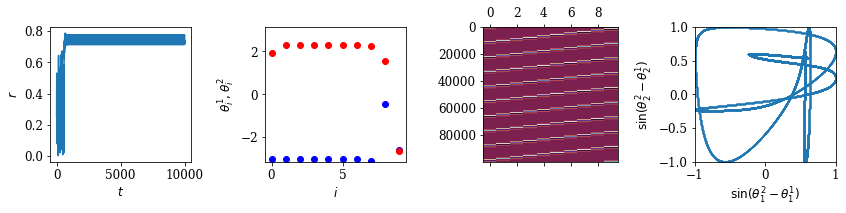

In [90]:
N=10
k=1
t1=10000
t3=9000
dt=0.01
sigma=0.35
beta=0.25
gamma=0.1
output=2
seed=1
omega=1

np.random.seed(seed)
phase_init = np.zeros(4*N,dtype=np.float64)
phi0=-np.pi+2*np.pi*np.random.random(N)
phi1=-np.pi+2*np.pi*np.random.random(N)
phase_init[:N] = np.cos(phi0)
phase_init[N:2*N] = np.sin(phi0)
phase_init[2*N:3*N] = np.cos(phi1)
phase_init[3*N:] = np.sin(phi1)

start = timeit.default_timer()
phases,times,order=janus.runsim(N, t1, t3, dt, omega, beta, sigma, gamma, phase_init)
stop = timeit.default_timer()
print('runtime: %f' % (stop - start))

phases=phases[int(t3/dt):]

phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

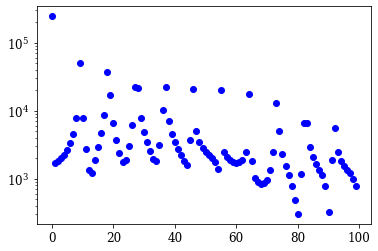

In [91]:
plt.yscale('log')
plt.plot(np.abs(np.fft.fft(phi0,axis=0))[:100,0],'bo')

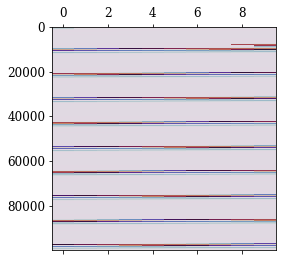

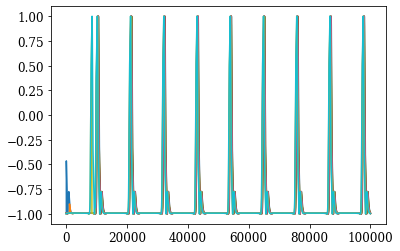

In [107]:
nu=10.5/dt
plt.matshow(np.transpose([np.cos(np.roll(phi0[:,i], 100+int(nu*i))) for i in range(N)]),aspect=len(phi0[0])/len(phi0),cmap='twilight')
plt.show()
plt.plot(np.transpose([np.cos(np.roll(phi0[:,i], 100+int(nu*i))) for i in range(N)]))
plt.show()

### A chaotic or invariant torus chimera state

runtime: 31.561605


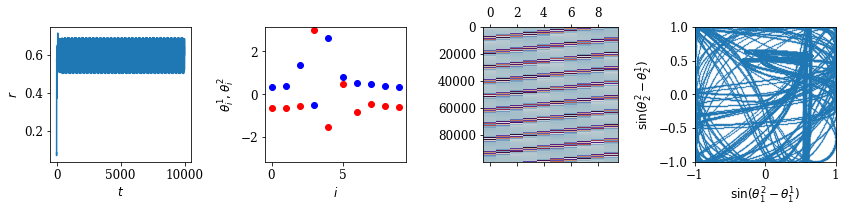

In [196]:
N=10
k=1
t1=10000
t3=9000
dt=0.01
sigma=0.35
beta=0.25
gamma=0.1
output=2
seed=9
omega=1

np.random.seed(seed)
phase_init = np.zeros(4*N,dtype=np.float64)
phi0=-np.pi+2*np.pi*np.random.random(N)
phi1=-np.pi+2*np.pi*np.random.random(N)
phase_init[:N] = np.cos(phi0)
phase_init[N:2*N] = np.sin(phi0)
phase_init[2*N:3*N] = np.cos(phi1)
phase_init[3*N:] = np.sin(phi1)

start = timeit.default_timer()
phases,times,order=janus.runsim(N, t1, t3, dt, omega, beta, sigma, gamma, phase_init)
stop = timeit.default_timer()
print('runtime: %f' % (stop - start))

phases=phases[int(t3/dt):]

phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

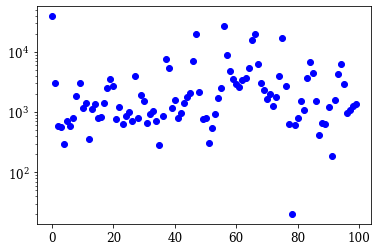

In [111]:
plt.yscale('log')
plt.plot(np.abs(np.fft.fft(phi0,axis=0))[:100,0],'bo')

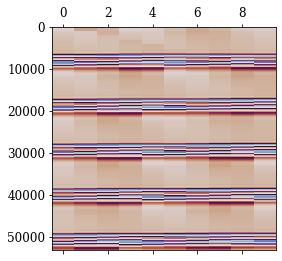

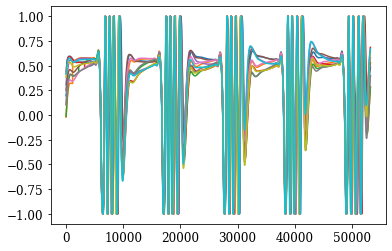

In [192]:
nmax=5*(int(len(phases)/10)+650)

phi0=np.arctan2(phases[:nmax,N:2*N],phases[:nmax,:N])
phi1=np.arctan2(phases[:nmax,3*N:],phases[:nmax,2*N:3*N])

nu=10.5/dt
plt.matshow(np.transpose([np.cos(np.roll(phi1[:,i], 100+int(nu*i))) for i in range(N)]),aspect=len(phi0[0])/len(phi0),cmap='twilight')
plt.show()
plt.plot(np.transpose([np.cos(np.roll(phi1[:,i], 100+int(nu*i))-phi0[:,0]) for i in range(N)]))
plt.show()

### The limit-cycle chimera can be found numerically as a boundary value problem

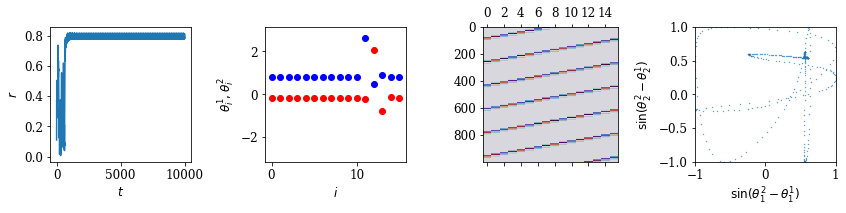

(array([ 3, 11, 19, 27, 35, 43]),)

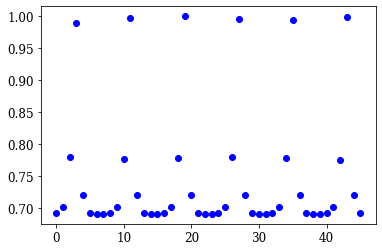

In [67]:
filebase='data/chimera2/11'
times=np.load(filebase+'times.npy')
order=np.load(filebase+'order.npy')
phases=np.load(filebase+'phases.npy')
fs=np.load(filebase+'fs.npy')
N=int((len(fs)+2)/4)
sigma0=0.35
omega=1
beta=0.25
gamma=0.1
phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

minds=find_peaks(phases[:,0])[0]
plt.plot(phases[minds,0],'bo')
np.where(phases[minds,0]>0.9)

(64, 175) 175.0


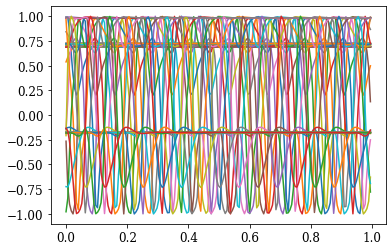

The algorithm converged to the desired accuracy. 473 143.5381849300029


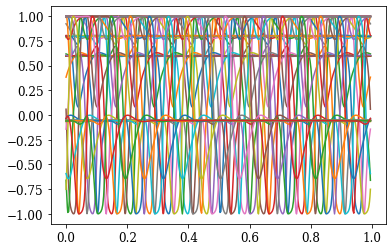

In [68]:
m0=3
m1=11
p0=times[minds[m1]]-times[minds[m0]]
Xts0=phases[minds[m0]:minds[m1]].T.copy()
ts0=(times[minds[m0]:minds[m1]]-times[minds[m0]])/p0
print(Xts0.shape,p0)
plt.plot(ts0,np.transpose(Xts0))
plt.show()

start=timeit.default_timer()
sol0=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma0, beta, gamma,sigma0,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), ts0, Xts0, p=np.array([p0]), max_nodes=1000,tol=1e-1,bc_tol=1e-2)
stop=timeit.default_timer()
print(sol0.message,len(sol0.x),stop-start)
plt.plot(sol0.x,np.transpose(sol0.y))
plt.show()

### Naive continuation works. We can add bifurcation detection if we calculate Floquet exponents and continue snaking in principle.

The algorithm converged to the desired accuracy.
0.350500	5.000e-04	477	175.711565	176.472998	0.004333	105.986917	
0.351000	5.000e-04	477	176.472998	177.245638	0.004378	53.137639	
0.351500	5.000e-04	484	177.245638	178.029464	0.004422	106.149709	
0.352000	5.000e-04	484	178.029464	178.825281	0.004470	53.645165	
0.352500	5.000e-04	488	178.825281	179.633028	0.004517	107.605122	
0.353000	5.000e-04	488	179.633028	180.453847	0.004569	54.767913	
0.353500	5.000e-04	488	180.453847	181.288016	0.004623	54.616533	
0.354000	5.000e-04	492	181.288016	182.135645	0.004676	94.643737	
0.354500	5.000e-04	492	182.135645	182.998013	0.004735	13.702968	
0.355000	1.000e-03	496	182.998013	183.875765	0.004797	108.574128	
0.356000	1.000e-03	500	183.875765	185.680763	0.009816	69.906792	
0.357000	1.000e-03	500	185.680763	187.557630	0.010108	29.645470	
0.358000	1.000e-03	500	187.557630	189.510908	0.010414	42.523614	
0.359000	1.000e-03	500	189.510908	191.553661	0.010779	42.580867	
0.360000	1.000e-03	504	191.553661	193

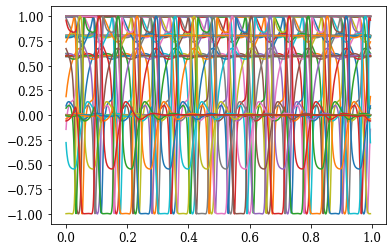

In [69]:
sols=[]
sigmas=[]
start=timeit.default_timer()

x0=sol0.x.copy()
y0=sol0.y.copy()
p0=sol0.p[0]
sigma=sigma0
sol=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), x0, y0, p=np.array([p0]), max_nodes=1000,tol=1e-1,bc_tol=1e-2)
print(sol.message)

dsigma=5e-4
dsigmamax=1e-3
dsigmamin=1e-6
sigmamin=0.325
sigmamax=0.373
count=1

while sol.success and sigma<sigmamax and sigma>sigmamin:
    #We could update the initial Xts and ts with an estimate based on Jacobian and dsigma (freezing the ts to the Xts value some way)
    sols.append(sol)
    sigmas.append(sigma)
    sigma=sigma+dsigma 
    if(sigma>sigmamax):
        sigma=sigmamax
    if(sigma<sigmamin):
        sigma=sigmamin
    
    x0=sol.x
    y0=sol.y
    p0=sol.p[0]
    
    try:
        start2=timeit.default_timer()
        sol=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), x0, y0, p=np.array([p0]), max_nodes=1000,tol=1e-1,bc_tol=1e-2)
        stop2=timeit.default_timer()

        if not sol.success:
            count=0
            raise Exception(sol.message)
        count=count+1
        if len(sol.x)>2*len(sols[-1].x):
            raise Exception('mesh increased too fast '+str(len(sol.x))+' '+str(len(sols[-1].x)))
        if (np.abs(np.max(y0)-np.max(sol.y))/np.max(y0)>5e-1):
            raise Exception('solution changed too much')
        if (np.abs((p0-sol.p[0])/p0)>5e-1):
            raise Exception('period changed too much '+ str(p0)+' '+str(sol.p[0]))
    except Exception as e:
        print('\n',str(e))
        sigma=sigma-dsigma
        dsigma=dsigma/2
        sol=sols[-1]
        print('\r%f\t%.3e\t%i\t%f\t%f\t%f\t%f\t'%(sigma, dsigma,len(sol.x),p0,sol.p[0],np.abs((p0-sol.p[0])/p0),stop2-start2),end='\n')

        if np.abs(dsigma)>dsigmamin:
            continue
        else:
            print('\nstep size too small')
            break
            
    if count>10:
        dsigma=np.sign(dsigma)*np.min([dsigmamax,np.abs(dsigma)*2])
        count=1
    print('\r%f\t%.3e\t%i\t%f\t%f\t%f\t%f\t'%(sigma, dsigma,len(sol.x),p0,sol.p[0],np.abs((p0-sol.p[0])/p0),stop2-start2),end='\n')

    
stop=timeit.default_timer()
print('\n',sol.message,len(sols),len(sols[0].x),len(sols[-1].x),stop-start)
plt.plot(sol.x,np.transpose(sol.y))
plt.show()

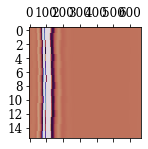

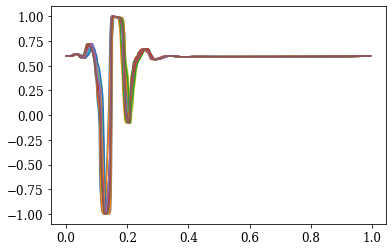

In [70]:
phases=sols[-1].y.T.copy()
phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
plt.matshow([np.cos(np.roll(theta[:,i], 100+int(len(theta)/N*i))) for i in range(N)],aspect=len(phi)/len(phi[0]),cmap='twilight')
plt.show()
plt.plot(sols[-1].x,np.transpose([np.cos(np.roll(theta[:,i], 100+int(len(theta)/N*i))) for i in range(N)]))
plt.show()

The algorithm converged to the desired accuracy.
0.349500	-5.000e-04	473	175.711565	174.960112	0.004277	53.242686	
0.349000	-5.000e-04	473	174.960112	174.218876	0.004237	52.848982	
0.348500	-5.000e-04	473	174.218876	173.487473	0.004198	52.922609	
0.348000	-5.000e-04	476	173.487473	172.765217	0.004163	107.414321	
0.347500	-5.000e-04	476	172.765217	172.052332	0.004126	53.379746	
0.347000	-5.000e-04	480	172.052332	171.347908	0.004094	106.064155	
0.346500	-5.000e-04	484	171.347908	170.652006	0.004061	107.771436	
0.346000	-5.000e-04	484	170.652006	169.964703	0.004028	55.670535	
0.345500	-5.000e-04	484	169.964703	169.283312	0.004009	14.798237	
0.345000	-1.000e-03	488	169.283312	168.613461	0.003957	40.747290	
0.344000	-1.000e-03	488	168.613461	167.292502	0.007834	58.091283	
0.343000	-1.000e-03	488	167.292502	165.999723	0.007728	42.954738	
0.342000	-1.000e-03	488	165.999723	164.734348	0.007623	15.816136	
0.341000	-1.000e-03	488	164.734348	163.492786	0.007537	29.776328	
0.340000	-1.000e-03	488	

0.250063	-3.125e-05	995	75.604064	75.452598	0.002003	112.048101	

 The maximum number of mesh nodes is exceeded.
0.250063	-1.563e-05	995	75.452598	75.452598	0.000000	113.990210	
0.250047	-1.563e-05	995	75.452598	75.380561	0.000955	111.580118	
0.250031	-1.563e-05	995	75.380561	75.307310	0.000972	111.334237	

 The maximum number of mesh nodes is exceeded.
0.250031	-7.813e-06	995	75.307310	75.307310	0.000000	115.001681	
0.250023	-7.813e-06	995	75.307310	75.267692	0.000526	85.075950	
0.250016	-7.813e-06	995	75.267692	75.238658	0.000386	112.284333	

 The maximum number of mesh nodes is exceeded.
0.250016	-3.906e-06	995	75.238658	75.238658	0.000000	114.008433	

 The maximum number of mesh nodes is exceeded.
0.250016	-1.953e-06	995	75.238658	75.238658	0.000000	115.800276	

 The maximum number of mesh nodes is exceeded.
0.250016	-9.766e-07	995	75.238658	75.238658	0.000000	112.794471	

step size too small

 The algorithm converged to the desired accuracy. 130 473 995 7781.676534477003


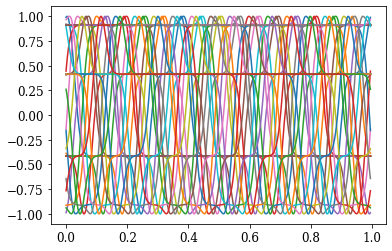

In [76]:
sols2=[]
sigmas2=[]
start=timeit.default_timer()

x0=sol0.x.copy()
y0=sol0.y.copy()
p0=sol0.p[0]
sigma=sigma0
sol=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), x0, y0, p=np.array([p0]), max_nodes=1000,tol=1e-1,bc_tol=1e-2)
print(sol.message)

dsigma=-5e-4
dsigmamax=1e-3
dsigmamin=1e-6
sigmamin=0.25
sigmamax=0.373
count=1

while sol.success and sigma<sigmamax and sigma>sigmamin:
    #We could update the initial Xts and ts with an estimate based on Jacobian and dsigma (freezing the ts to the Xts value some way)
    sols2.append(sol)
    sigmas2.append(sigma)
    sigma=sigma+dsigma 
    if(sigma>sigmamax):
        sigma=sigmamax
    if(sigma<sigmamin):
        sigma=sigmamin
    
    x0=sol.x.copy()
    y0=sol.y.copy()
    p0=sol.p[0]
    
    try:
        start2=timeit.default_timer()
        sol=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), x0, y0, p=np.array([p0]), max_nodes=1000,tol=1e-1,bc_tol=1e-2)        
        stop2=timeit.default_timer()

        if not sol.success:
            count=1
            raise Exception(sol.message)
        count=count+1
        if len(sol.x)>2*len(sols2[-1].x):
            raise Exception('mesh increased too fast '+str(len(sol.x))+' '+str(len(sols[-1].x)))
        if (np.abs(np.max(y0)-np.max(sol.y))/np.max(y0)>5e-1):
            raise Exception('solution changed too much')
        if (np.abs((p0-sol.p[0])/p0)>5e-1):
            raise Exception('period changed too much '+ str(p0)+' '+str(sol.p[0]))
    except Exception as e:
        print('\n',str(e))
        sigma=sigma-dsigma
        dsigma=dsigma/2
        sol=sols2[-1]
        print('\r%f\t%.3e\t%i\t%f\t%f\t%f\t%f\t'%(sigma, dsigma,len(sol.x),p0,sol.p[0],np.abs((p0-sol.p[0])/p0),stop2-start2),end='\n')

        if np.abs(dsigma)>dsigmamin:
            continue
        else:
            print('\nstep size too small')
            break
            
    if count>10:
        dsigma=np.sign(dsigma)*np.min([dsigmamax,np.abs(dsigma)*2])
        count=1
    print('\r%f\t%.3e\t%i\t%f\t%f\t%f\t%f\t'%(sigma, dsigma,len(sol.x),p0,sol.p[0],np.abs((p0-sol.p[0])/p0),stop2-start2),end='\n')

    
stop=timeit.default_timer()
print('\n',sol.message,len(sols2),len(sols2[0].x),len(sols2[-1].x),stop-start)
plt.plot(sol.x,np.transpose(sol.y))
plt.show()

In [81]:
int(len(theta)/N)

41

In [85]:
sols2[-1].p[0]/16

4.702416118363531

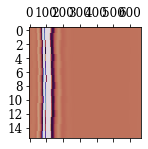

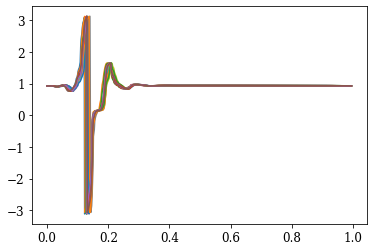

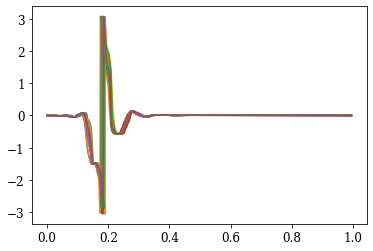

In [89]:
phases=sols[-1].y.T.copy()
phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
plt.matshow([np.cos(np.roll(theta[:,i], 100+int(len(theta)/N*i))) for i in range(N)],aspect=len(phi)/len(phi[0]),cmap='twilight')
plt.show()
plt.plot(sols[-1].x, np.transpose([np.roll(theta[:,i], 100+int(len(theta)/N*i)) for i in range(N)]))
plt.show()
plt.plot(sols[-1].x, np.transpose([np.roll(phi[:,i], 100+int(len(theta)/N*i)) for i in range(N)]))
plt.show()

In [78]:
Sigmas=[sigmas2[-i] for i in range(1,len(sols2))]+[sigmas[i] for i in range(len(sols))]
Periods=[sols2[-i].p[0] for i in range(1,len(sols2))]+[sols[i].p[0] for i in range(len(sols))]
Ts=[sols2[-i].x for i in range(1,len(sols2))]+[sols[i].x for i in range(len(sols))]
Ys=[sols2[-i].y for i in range(1,len(sols2))]+[sols[i].y for i in range(len(sols))]
np.save(filebase+'lcsigmas.npy',Sigmas)
np.save(filebase+'lcperiods.npy',Periods)
for i in range(len(Sigmas)):
    np.save(filebase+'lctimes_'+str(i)+'.npy',Ts[i])
    np.save(filebase+'lcphases_'+str(i)+'.npy',Ys[i])

### Plot order parameter

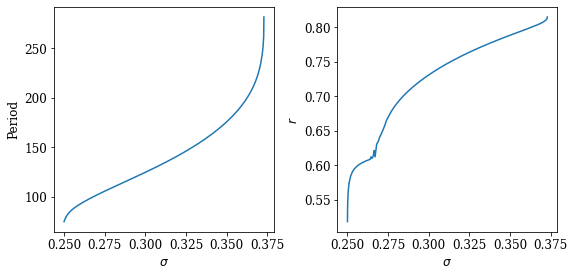

In [79]:
Sigmas=np.load(filebase+'lcsigmas.npy')
Periods=np.load(filebase+'lcperiods.npy')
Ts=[]
Ys=[]
for i in range(len(Sigmas)):
    Ts.append(np.load(filebase+'lctimes_'+str(i)+'.npy'))
    Ys.append(np.load(filebase+'lcphases_'+str(i)+'.npy'))
    Orders=[]
for i in range(len(Ys)):
    phases=Ys[i].T.copy()
    phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
    theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
    r=np.abs(np.sum(phases[:,:N]+1j*phases[:,N:2*N],axis=1)+np.sum(phases[:,2*N:3*N]+1j*phases[:,3*N:],axis=1))/(2*N)
    Orders.append(np.sum(r[:-1]*np.diff(Ts[i])))
    
plt.subplots(1,2,figsize=(8,4))
plt.subplot(1,2,1)
plt.xlabel('$\sigma$')
plt.ylabel('Period')
plt.plot(Sigmas,Periods)
plt.subplot(1,2,2)
plt.xlabel('$\sigma$')
plt.ylabel('$r$')
plt.plot(Sigmas,Orders)

plt.tight_layout()
plt.show()

### Try to the solution around at the limit point by extrapolating the period

The algorithm converged to the desired accuracy. 666 77.18232568299572


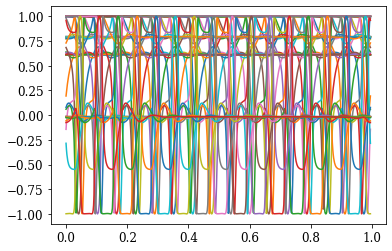

301.46792580577994 281.6003025917823 290.198421455222


In [251]:
N=16
p0=2*Periods[-1]-Periods[-2]
Xts0=Ys[-1]
ts0=Ts[-1]
sigma0=Sigmas[-2]

start=timeit.default_timer()
sol0=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma0, beta, gamma,sigma0,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), ts0, Xts0, p=np.array([p0]), max_nodes=1000,tol=1e-1,bc_tol=1e-2)
stop=timeit.default_timer()
print(sol0.message,len(sol0.x),stop-start)
plt.plot(sol0.x,np.transpose(sol0.y))
plt.show()
print(p0, Periods[-1], sol0.p[0])

In [ ]:
sols2=[]
sigmas2=[]
start=timeit.default_timer()

x0=sol0.x.copy()
y0=sol0.y.copy()
p0=sol0.p[0]
sigma=sigma0
sol=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), x0, y0, p=np.array([p0]), max_nodes=1000,tol=1e-1,bc_tol=1e-2)
print(sol.message)

dsigma=-5e-4
dsigmamax=1e-3
dsigmamin=1e-6
sigmamin=0.25
sigmamax=0.373
count=1

while sol.success and sigma<sigmamax and sigma>sigmamin:
    #We could update the initial Xts and ts with an estimate based on Jacobian and dsigma (freezing the ts to the Xts value some way)
    sols2.append(sol)
    sigmas2.append(sigma)
    sigma=sigma+dsigma 
    if(sigma>sigmamax):
        sigma=sigmamax
    if(sigma<sigmamin):
        sigma=sigmamin
    
    x0=sol.x.copy()
    y0=sol.y.copy()
    p0=sol.p[0]
    
    try:
        start2=timeit.default_timer()
        sol=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), x0, y0, p=np.array([p0]), max_nodes=1000,tol=1e-1,bc_tol=1e-2)        
        stop2=timeit.default_timer()

        if not sol.success:
            count=1
            raise Exception(sol.message)
        count=count+1
        if len(sol.x)>2*len(sols2[-1].x):
            raise Exception('mesh increased too fast '+str(len(sol.x))+' '+str(len(sols[-1].x)))
        if (np.abs(np.max(y0)-np.max(sol.y))/np.max(y0)>5e-1):
            raise Exception('solution changed too much')
        if (np.abs((p0-sol.p[0])/p0)>5e-1):
            raise Exception('period changed too much '+ str(p0)+' '+str(sol.p[0]))
    except Exception as e:
        print('\n',str(e))
        sigma=sigma-dsigma
        dsigma=dsigma/2
        sol=sols2[-1]
        print('\r%f\t%.3e\t%i\t%f\t%f\t%f\t%f\t'%(sigma, dsigma,len(sol.x),p0,sol.p[0],np.abs((p0-sol.p[0])/p0),stop2-start2),end='\n')

        if np.abs(dsigma)>dsigmamin:
            continue
        else:
            print('\nstep size too small')
            break
            
    if count>10:
        dsigma=np.sign(dsigma)*np.min([dsigmamax,np.abs(dsigma)*2])
        count=1
    print('\r%f\t%.3e\t%i\t%f\t%f\t%f\t%f\t'%(sigma, dsigma,len(sol.x),p0,sol.p[0],np.abs((p0-sol.p[0])/p0),stop2-start2),end='\n')

    
stop=timeit.default_timer()
print('\n',sol.message,len(sols2),len(sols2[0].x),len(sols2[-1].x),stop-start)
plt.plot(sol.x,np.transpose(sol.y))
plt.show()

The algorithm converged to the desired accuracy.
0.372375	-5.000e-04	673	290.465818	310.533961	0.069090	194.947029	

 The maximum number of mesh nodes is exceeded.
0.372375	-2.500e-04	673	310.533961	310.533961	0.000000	76.913786	
0.372125	-2.500e-04	673	310.533961	318.206482	0.024708	76.130125	
0.371875	-2.500e-04	697	318.206482	325.098383	0.021659	319.663515	
0.371625	-2.500e-04	697	325.098383	331.733439	0.020409	87.424543	
0.371375	-2.500e-04	700	331.733439	338.091733	0.019167	101.267178	
0.371125	-2.500e-04	705	338.091733	344.245779	0.018202	242.280777	
0.370875	-2.500e-04	708	344.245779	350.262576	0.017478	124.512772	


In [ ]:
plt.plot(Sigmas,Periods)
plt.plot(sigmas2,periods2)
plt.show()